In [30]:
import os
import scipy

import keras
import matplotlib.image as mpimg
import matplotlib.patches as matplotlib_patches
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.layers import Input
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

from functions_v1 import *

% matplotlib inline
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
n = 100  # number of image to load

# Loaded a set of images
root_dir = "datas/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
files.sort()
n = min(n, len(files))  # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = np.array([load_image(image_dir + files[i]) for i in range(n)])
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " groundtruth")
gt_imgs = np.array([load_image(gt_dir + files[i]) for i in range(n)])
print(files[0])

Loading 100 images
satImage_001.png
Loading 100 groundtruth
satImage_001.png


## Discretize Y

In [3]:
Y = gt_imgs.reshape(100*400*400)
for i in range(len(Y)):
    Y[i] = round(Y[i])
Y = Y.reshape(100, 400, 400)

## Autoencoder

In [5]:
def SegNet(input_shape=(400, 400, 3), classes=2):
    img_input = Input(shape=input_shape)
    x = img_input
    
    # Encoder
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Decoder
    x = Conv2D(512, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(classes, (1, 1), padding="valid")(x)
    x = Reshape((input_shape[0] * input_shape[1], classes))(x)
    x = Activation("softmax")(x)
    model = Model(img_input, x)
    return model

In [13]:
input_shape = (400, 400, 3)
classes = 2
epochs = 10
batch_size = 4

In [7]:
x_train, x_test, y_train, y_test = train_test_split(imgs, Y, test_size=0.1, random_state=42)

In [9]:
y_train_categorical = keras.utils.to_categorical(np.array(y_train).reshape(len(y_train), 160000), num_classes=2)
y_test_categorical = keras.utils.to_categorical(np.array(y_test).reshape(len(y_test), 160000), num_classes=2)

In [10]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', np.array([0, 1]), Y.reshape(len(Y)*400*400))
class_weight

array([ 0.62536613,  2.49415899])

In [14]:
model = SegNet(input_shape=input_shape, classes=classes)
model.compile(loss="categorical_crossentropy", optimizer='adadelta', metrics=["accuracy"])

model.fit(x_train, y_train_categorical, batch_size=batch_size, epochs=epochs,
          verbose=1, class_weight=class_weight , validation_data=(x_test, y_test_categorical), shuffle=True)

Train on 90 samples, validate on 10 samples
Epoch 1/10
24/90 [=======>......................] - ETA: 10:07 - loss: 0.7229 - acc: 0.6083

KeyboardInterrupt: 

In [ ]:
score = model.evaluate(x_test, y_test_categorical, batch_size)
score

In [ ]:
model.save_weights("./weights/segnet.h5")

In [37]:
predictions = model.predict(imgs[0:1])

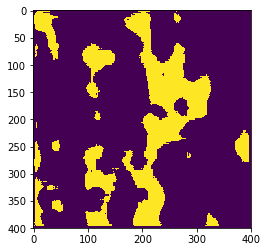

In [38]:
plt.imshow(np.argmax(predictions[0], axis=1).reshape(400,400))

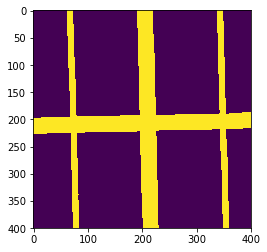

In [39]:
plt.imshow(Y[0])

## Test

In [27]:
test_dir = "datas/test_set_images/"
files = os.listdir(test_dir)
n = min(100, len(files))  # Load maximum 20 images
files.sort()
print("Loading " + str(n) + " images")
test_imgs = np.array([load_image(test_dir + files[i] + '/' + os.listdir(test_dir + files[i])[0]) for i in range(n)])
print("Loaded !")

Loading 50 images
Loaded !


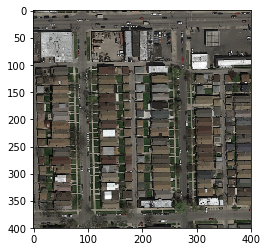

In [33]:
resized = scipy.misc.imresize(test_imgs[0], size=(400, 400))
plt.imshow(resized)

In [40]:
predictions = model.predict(np.array([resized]))

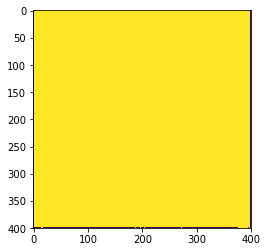

In [41]:
plt.imshow(np.argmax(predictions[0], axis=1).reshape(400,400))